In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import gc
import matplotlib.image as mpimg
import seaborn as sns
# Keras 
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img 
from keras.preprocessing import image
from tqdm import tqdm
import tensorflow as tf

In [2]:
path_to_folder_train = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Training"
image_paths = os.listdir(path_to_folder_train)
train = [path_to_folder_train+"/"+i for i in image_paths]

path_to_folder_validate = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Validation"
image_paths = os.listdir(path_to_folder_validate)
validate= [path_to_folder_validate+"/"+i for i in image_paths]

path_to_folder_test = "/Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Testing"
image_paths = os.listdir(path_to_folder_test)
test = [path_to_folder_test+"/"+i for i in image_paths]

In [3]:
#train_imgs = train_zebras[:400] + train_eliphants[:400]
train_imgs = train
random.shuffle(train_imgs)

del train
gc.collect()

44

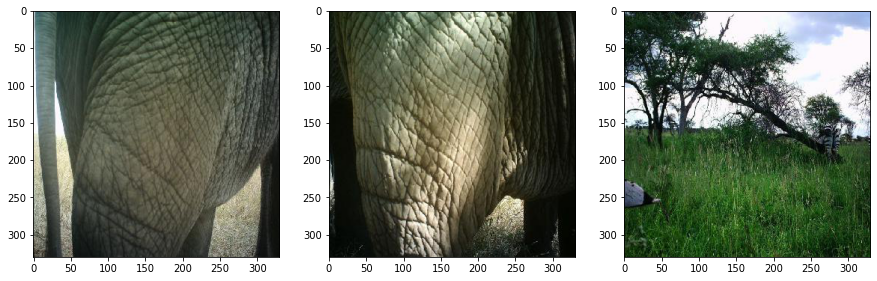

In [4]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i,ima in enumerate(train_imgs[0:3]):
    img = mpimg.imread(ima)
    imgplot = ax[i].imshow(img)
plt.show() 

In [5]:
#We can change this later, if we want
nrows = 64
ncolums = 64 
channels = 3

In [6]:
def read_and_process_image(list_of_images):
    x = []
    y = []
    for image in tqdm(list_of_images):
        try:
            x.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR) , (nrows, ncolums) , interpolation = cv2.INTER_CUBIC))
        except:
            print("An image caused a probelem",image)
            continue
        if "elephant" in image:
            y.append(0)
        else:
            y.append(1)   
    return x,y

In [7]:
X, y = read_and_process_image(train_imgs)
del train_imgs
gc.collect()

  4%|▍         | 445/10000 [00:01<00:31, 302.99it/s]

An image caused a probelem /Users/tomashegewisch/Downloads/data_sets_for_lunch_lab/Training/IMG10288_zebra.jpeg


100%|██████████| 10000/10000 [00:31<00:00, 316.39it/s]


42

/Users/tomashegewisch/lunch_lab_project_final/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


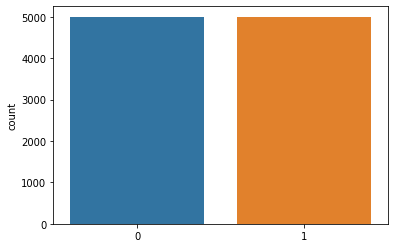

In [8]:
X = np.array(X)
y = np.array(y)
sns.countplot(y)
plt.show()

In [9]:
print("The shape of x:", X.shape)
print("The shape of y:", y.shape)
# X -> batch size, height, width and channels

The shape of x: (9999, 64, 64, 3)
The shape of y: (9999,)


#"The model takes as input an array of ( height, width,channels)"

In [10]:
# split the data into train and validation
X_train = X 
y_train = y

X_val, y_val = read_and_process_image(validate)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_test, y_test = read_and_process_image(test)
X_test = np.array(X_test)
y_test = np.array(y_test)

del validate
del test

100%|██████████| 2000/2000 [00:07<00:00, 271.58it/s]


In [11]:
print("The shape of X_train:",X_train.shape)
print("The Shape of X_val:", X_val.shape)
print("The shape of y_train:",y_train.shape)
print("The shape of y_val:", y_val.shape)

The shape of X_train: (9999, 64, 64, 3)
The Shape of X_val: (2000, 64, 64, 3)
The shape of y_train: (9999,)
The shape of y_val: (2000,)


In [12]:
#clear
del X
del y
gc.collect()

2427

In [13]:
ntrain = len(X_train)
nval = len(X_val)

In [14]:
batch_size = 32 

In [15]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# training_set = train_datagen.flow_from_directory(
#         directory=direc,
#         target_size=(64,64),
#         batch_size=32,
#         class_mode='binary')
training_set =  train_datagen.flow(X_train, y_train, batch_size = batch_size)

In [16]:
valid_datagen = ImageDataGenerator(rescale=1./255)
# valid_direc = os.path.join(base_dir, 'Valid')

# validation_set = valid_datagen.flow_from_directory(
#     directory=valid_direc,
#     target_size=(64,64),
#     batch_size=32,
#     class_mode = 'binary')
validation_set = valid_datagen.flow(X_val, y_val, batch_size= batch_size)

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)
# test_set = test_datagen.flow_from_directory(
#         directory=test_direc,
#         target_size=(64, 64),
#         batch_size=32,
#         class_mode='binary',
#         seed=42)
test_set = valid_datagen.flow(X_test, y_test, batch_size= batch_size)

In [18]:
# Simone's
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               802944    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [19]:
# Tomas's 
# cnn = models.Sequential()
# cnn.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape =(64, 64, 3)))
# cnn.add(layers.MaxPooling2D ((2, 2)))
# cnn.add(layers.Conv2D(64, (3,3), activation = "relu"))
# cnn.add(layers.MaxPooling2D ((2,2)))
# cnn.add(layers.Conv2D(128, (3,3), activation = "relu"))
# cnn.add(layers.MaxPooling2D((2,2)))
# cnn.add(layers.Conv2D(128, (3,3), activation = "relu"))
# cnn.add(layers.MaxPooling2D((2,2)))
# cnn.add(layers.Flatten())
# cnn.add(layers.Dropout(0.5)) # Dropot of regularisation
# cnn.add(layers.Dense(512, activation = "relu"))
# cnn.add(layers.Dense(1, activation = 'sigmoid'))
# cnn.summary()

Complie

In [20]:
optimmizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
cnn.compile(optimizer=optimmizer, loss='binary_crossentropy', metrics=['accuracy'])
# alpha=0.001, beta1=0.9, beta2=0.999 and epsilon=10−8
# cnn.compile(loss = 'binary_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-14), metrics = ['accuracy'])

In [21]:
history = cnn.fit(training_set, 
        validation_data = validation_set, 
        epochs = 5)

Epoch 1/5
313/313 [==============================] - 62s 197ms/step - loss: 0.5731 - accuracy: 0.6817 - val_loss: 0.4402 - val_accuracy: 0.7890
Epoch 2/5
313/313 [==============================] - 49s 155ms/step - loss: 0.3334 - accuracy: 0.8569 - val_loss: 0.2561 - val_accuracy: 0.8890
Epoch 3/5
313/313 [==============================] - 46s 147ms/step - loss: 0.2607 - accuracy: 0.8884 - val_loss: 0.3410 - val_accuracy: 0.8605
Epoch 4/5
313/313 [==============================] - 47s 150ms/step - loss: 0.2355 - accuracy: 0.9061 - val_loss: 0.2010 - val_accuracy: 0.9160
Epoch 5/5
313/313 [==============================] - 51s 163ms/step - loss: 0.1996 - accuracy: 0.9185 - val_loss: 0.1941 - val_accuracy: 0.9265


Text(0.5, 1.0, 'Training and validation loss')

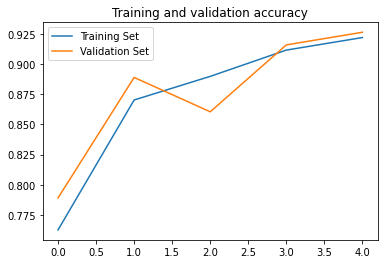

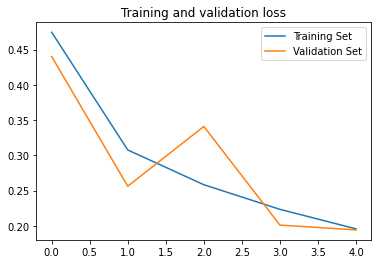

In [22]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training Set')
plt.plot(epochs, val_acc, label='Validation Set')
plt.legend()
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training Set')
plt.plot(epochs, val_loss, label='Validation Set')
plt.legend()
plt.title('Training and validation loss')

In [23]:
_, acc = cnn.evaluate(test_set, steps=len(test_set), verbose=0)
print('Test Accuracy: %.3f' % (acc * 100))

Test Accuracy: 92.450


0.0


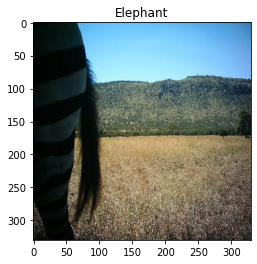

In [24]:
path_to_folder = '/Users/tomashegewisch/Downloads/data_set/test/'
image_paths = os.listdir(path_to_folder)
file = np.random.choice(image_paths)
path_to_test_image = path_to_folder + file
test_image = image.load_img(path_to_test_image, target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)

print(result[0][0])
if result[0][0] == 1:
    prediction = 'Zebra'
else:
    prediction = 'Elephant'

img = mpimg.imread(path_to_test_image)
imgplot = plt.imshow(img)
plt.title(prediction)
plt.show()

# ADAM
* Appropriate for problems with very noisy/or sparse gradients.
* Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).
* Adam is a popular algorithm in the field of deep learning because it achieves good results fast.
* 